In [1]:
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# How to clean data
- For Convolutional Neural Network
    1. normalize data
    1. augment training dataset
- For K nearest neighbors
    1. grayscale data
    1. use k neighbors clustering to remove outliers

In [6]:
# Training set for convolutional neural network
(X_train_cnn, y_train_cnn), (X_test_cnn, y_test_cnn) = (X_train, y_train), (X_test, y_test)

## Normalize data to values between 0 and 1

In [7]:
X_train_cnn, X_test_cnn = X_train_cnn/255.0, X_test_cnn/255.0

## Augment training dataset to 100,000 

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

(100000,)
(100000, 32, 32, 3)


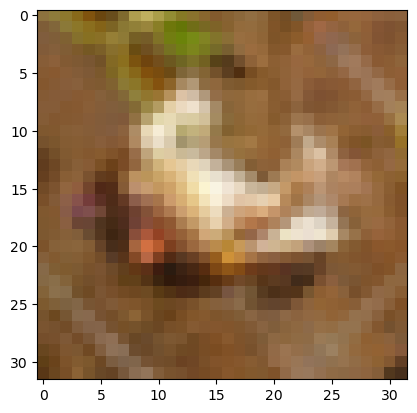

In [28]:
# plt.figure(figsize=(10, 10))
# image = X_train_cnn[5]
# print(image.shape)

# augmented_image = data_augmentation(image)
# ax = plt.subplot(3, 3, 2)
# plt.imshow(augmented_image)
# plt.axis("off")
# print(augmented_image.shape)

temp_train = np.zeros((100000, 32,32,3))
temp_test = np.zeros(100000)
for i in range(X_train_cnn.shape[0]):
    image = X_train_cnn[i]
    augmented_image = data_augmentation(image)
    temp_train[i*2] = X_train_cnn[i]
    temp_train[i*2+1] = augmented_image
    temp_test[i*2], temp_test[i*2+1] = y_train_cnn[i],y_train_cnn[i]

print(temp_test.shape)
print(temp_train.shape)


plt.imshow(temp_train[1])

6.0
6.0


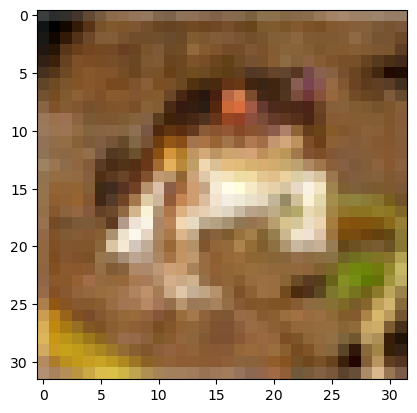

In [30]:
plt.imshow(temp_train[0])
print(temp_test[0])
print(temp_test[1])

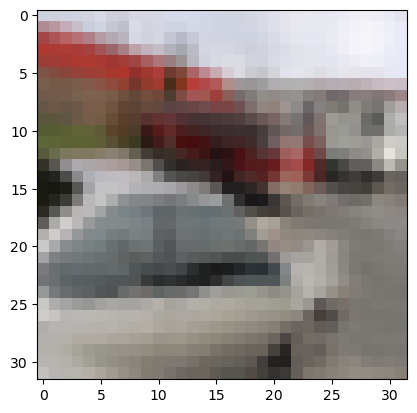

In [31]:
plt.imshow(temp_train[-1])


1.0
1.0


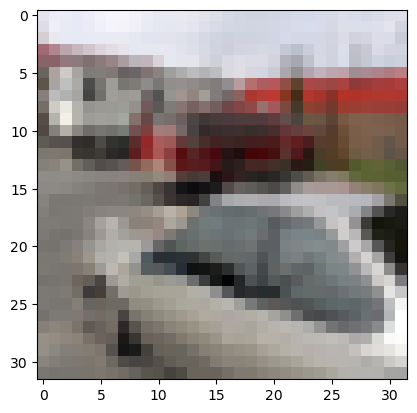

In [32]:
plt.imshow(temp_train[-2])
print(temp_test[-1])
print(temp_test[-2])

## Set our training set to temp and delete temp

In [33]:
X_train_cnn = temp_train
y_train_cnn = temp_test

print(y_train_cnn[0])
print(y_train_cnn[1])

6.0
6.0


In [34]:
del temp_test
del temp_train

## Nueral Network Architecture
- Implement Alexnet Architecture
- Hyperparameters to tune
    1. First convolutional layer window size
    1. First, second, third maxpooling layers filter size


In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import keras_tuner

def build_model(hp):
    model = Sequential()
    conv_filter_1 = hp.Choice('conv_filter_1', [2, 4])
    conv_stride_1 = hp.Choice('conv_stride_1', [2,4])
    # Layer 1: Convolutional layer with 64 filters of size 11x11x3
    model.add(Conv2D(filters=64, kernel_size=(conv_filter_1, conv_filter_1), strides=(conv_stride_1,conv_stride_1), padding='valid', activation='relu', input_shape=(32,32,3)))

    # Layer 2: Max pooling layer with pool size of 3x3
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
    model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 6: Fully connected layer with 4096 neurons
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    # Layer 7: Fully connected layer with 4096 neurons
    model.add(Dense(4096, activation='relu'))

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [ ]:
tuner.search(X_train_cnn[:90000], y_train_cnn[:90000], epochs=5, validation_data=(X_train_cnn[90000:], y_train_cnn[90000:]))
best_model = tuner.get_best_models()[0]

## Test and evaluate CNN
- Confusion Matrix
- Accuracy, Precision, Recall, and F1 Score

# Clean Data for K-neighbors classifier
- For K nearest neighbors
    1. grayscale data
    1. use k neighbors clustering to remove outliers

(10000, 32, 32)


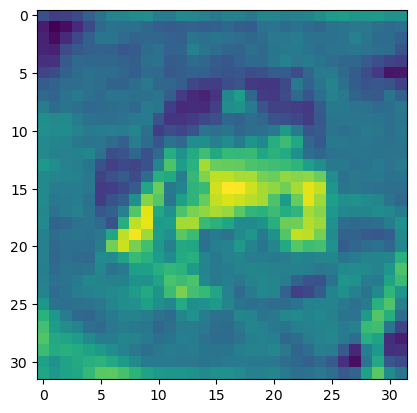

In [36]:
from skimage import data
from skimage.color import rgb2gray
# go through dataset
# set all images to grayscale
X_train_knn = np.zeros((50000,32,32))
X_test_knn = np.zeros((10000,32,32))
for i in range(X_train.shape[0]):
    X_train_knn[i] = rgb2gray(X_train[i])
for i in range(X_test.shape[0]):
    X_test_knn[i] = rgb2gray(X_test[i])

X_train_knn = X_train_knn/255.0
X_test_knn = X_test_knn/255.0
print(X_test_knn.shape)
plt.imshow(X_train_knn[0])

In [10]:
X_train_knn.reshape((50000,32*32)).shape

(50000, 1024)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X = X_train_knn.reshape((50000,32*32)), y=y_train)

/Users/noahcampise/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [38]:
y_pred = model.predict(X_test_knn.reshape((10000,32*32)))

In [27]:
y_test.shape

(10000, 1)

## KNN metrics
- Confusion Matrix
- Precision, Recall, F1 score, Accuracy

<Axes: >

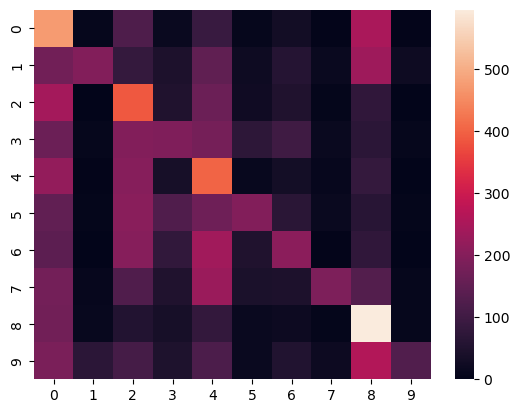

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix = confusion_matrix(y_test, y_pred.reshape(10000,1))

seaborn.heatmap(confusion_matrix)

In [47]:
import sklearn.metrics

print('Accuracy: ',sklearn.metrics.accuracy_score(y_pred=y_pred.reshape(10000,1), y_true=y_test))
print('F1 Score: ',sklearn.metrics.f1_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))
print('Precision: ',sklearn.metrics.precision_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))
print('Recall: ',sklearn.metrics.recall_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))

Accuracy:  0.2963
F1 Score:  0.2854845178063419
Precision:  0.4010418775150852
Recall:  0.2963


## It is not very good, lets do some hyperparameter tuning

In [9]:

from sklearn.model_selection import GridSearchCV
param_grid = [
  { 
      'n_neighbors': [3,5],
      'weights': ['uniform', 'distance']
  }
]

model = KNeighborsClassifier()

gridSearch = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring="accuracy")


TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'